<a href="https://colab.research.google.com/github/meinicharat/Automated-CISA-KEV-Risk-Analytics/blob/main/Automated_CISA_KEV_Risk_Analytics_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [61]:
!pip -q install pandas sqlalchemy sqlite-utils altair python-dateutil


In [62]:
import sys, os, math
import pandas as pd
import sqlalchemy as sa
import sqlite3
import altair as alt
import numpy as np

In [63]:
os.makedirs("exports", exist_ok=True)

In [64]:
print("Python:", sys.version.split()[0])
print("pandas:", pd.__version__)
print("SQLAlchemy:", sa.__version__)
print("sqlite3 (client):", sqlite3.sqlite_version)
print("Altair:", alt.__version__)

Python: 3.12.12
pandas: 2.2.2
SQLAlchemy: 2.0.45
sqlite3 (client): 3.37.2
Altair: 5.5.0


In [65]:
try:
    con = sqlite3.connect(":memory:")
    cur = con.cursor()
    cur.execute("PRAGMA compile_options;")
    opts = [r[0] for r in cur.fetchall()]
    con.close()
    print("SQLite compile options:")
    for o in opts[:10]:
        print(" -", o)
except Exception as e:
    print("ตรวจ PRAGMA ไม่สำเร็จ:", e)

print("\n[SUMMARY] Environment is ready. Created folder: ./exports")

SQLite compile options:
 - ATOMIC_INTRINSICS=1
 - COMPILER=gcc-11.4.0
 - DEFAULT_AUTOVACUUM
 - DEFAULT_CACHE_SIZE=-2000
 - DEFAULT_FILE_FORMAT=4
 - DEFAULT_JOURNAL_SIZE_LIMIT=-1
 - DEFAULT_MMAP_SIZE=0
 - DEFAULT_PAGE_SIZE=4096
 - DEFAULT_PCACHE_INITSZ=20
 - DEFAULT_RECURSIVE_TRIGGERS

[SUMMARY] Environment is ready. Created folder: ./exports


In [66]:
url = "https://www.cisa.gov/sites/default/files/csv/known_exploited_vulnerabilities.csv"
df_raw = pd.read_csv(url, low_memory=False)

In [67]:
print("[RAW] Shape:", df_raw.shape)
print("[RAW] Total columns:", len(df_raw.columns))
print("[RAW] Columns (all):")
print(" | ".join(df_raw.columns.tolist()))

[RAW] Shape: (1482, 11)
[RAW] Total columns: 11
[RAW] Columns (all):
cveID | vendorProject | product | vulnerabilityName | dateAdded | shortDescription | requiredAction | dueDate | knownRansomwareCampaignUse | notes | cwes


In [68]:
rename_map = {
    "cveID": "cve_id",
    "vendorProject": "vendor",
    "vulnerabilityName": "vuln_name",
    "dateAdded": "date_added",
    "shortDescription": "short_desc",
    "requiredAction": "required_action",
    "dueDate": "due_date",
    "knownRansomwareCampaignUse": "known_ransomware_use",
    "cwes": "cwe",
}

raw_cols = set(df_raw.columns)
present_to_rename = {k: v for k, v in rename_map.items() if k in raw_cols}
df = df_raw.rename(columns=present_to_rename)

In [69]:
for col in ["date_added", "due_date"]:
    if col in df.columns:
        df[col] = pd.to_datetime(df[col], errors="coerce", utc=True)

In [70]:
for col in ["cve_id", "vendor", "product", "vuln_name"]:
    if col in df.columns:
        df[col] = (
            df[col].astype(str)
                  .str.strip()
                  .str.replace(r"\s+", " ", regex=True)
                  )

In [71]:
for rc in ["cve_id", "date_added"]:
    if rc not in df.columns:
        df[rc] = np.nan
before_dropna = len(df)
df = df.dropna(subset=["cve_id", "date_added"])
after_dropna = len(df)

In [72]:
before_dedup = len(df)
df = df.drop_duplicates(subset=["cve_id", "vendor", "product", "date_added"]).reset_index(drop=True)
after_dedup = len(df)

In [73]:
#เอาไว้ดูรายเดือนได้
df["month_key"] = df["date_added"].dt.strftime("%Y-%m")

In [74]:
#summary
date_min = df["date_added"].min()
date_max = df["date_added"].max()
n_vendor = df["vendor"].nunique() if "vendor" in df.columns else None

In [75]:
print("[CLEAN] Rows after dropna:", after_dropna, f"(removed {before_dropna - after_dropna})")
print("[CLEAN] Rows after dedupe:", after_dedup, f"(removed {before_dedup - after_dedup})")
print(f"[CLEAN] Date range: {date_min} -> {date_max}")
print(f"[CLEAN] Unique vendors: {n_vendor}")
print("\nSample rows:")
print(df[["cve_id","vendor","product","date_added","month_key"]].head(8).to_string(index=False))

[CLEAN] Rows after dropna: 1482 (removed 0)
[CLEAN] Rows after dedupe: 1482 (removed 0)
[CLEAN] Date range: 2021-11-03 00:00:00+00:00 -> 2025-12-19 00:00:00+00:00
[CLEAN] Unique vendors: 242

Sample rows:
        cve_id          vendor                 product                date_added month_key
CVE-2025-14733      WatchGuard                 Firebox 2025-12-19 00:00:00+00:00   2025-12
CVE-2025-59374            ASUS             Live Update 2025-12-17 00:00:00+00:00   2025-12
CVE-2025-40602       SonicWall       SMA1000 appliance 2025-12-17 00:00:00+00:00   2025-12
CVE-2025-20393           Cisco       Multiple Products 2025-12-17 00:00:00+00:00   2025-12
CVE-2025-59718        Fortinet       Multiple Products 2025-12-16 00:00:00+00:00   2025-12
CVE-2025-14611        Gladinet CentreStack and Triofox 2025-12-15 00:00:00+00:00   2025-12
CVE-2025-43529           Apple       Multiple Products 2025-12-15 00:00:00+00:00   2025-12
 CVE-2018-4063 Sierra Wireless           AirLink ALEOS 2025-12-12 0

In [76]:
missing_pct = df.isna().mean().sort_values(ascending=False) * 100
print("\n[Missing % Top 8]\n", missing_pct.head(8).round(2).to_string())


[Missing % Top 8]
 cwe                11.2
cve_id              0.0
product             0.0
vendor              0.0
vuln_name           0.0
date_added          0.0
required_action     0.0
short_desc          0.0


In [77]:
print(df.shape)

(1482, 12)


In [78]:
df[df["cwe"].isna()]

,cve_id,vendor,product,vuln_name,date_added,short_desc,required_action,due_date,known_ransomware_use,notes,cwe,month_key
8,CVE-2025-14174,Google,Chromium,Google Chromium Out of Bounds Memory Access Vu...,2025-12-12 00:00:00+00:00,Google Chromium contains an out of bounds memo...,"Apply mitigations per vendor instructions, fol...",2026-01-02 00:00:00+00:00,Unknown,https://chromereleases.googleblog.com/2025/12/...,NaN,2025-12
14,CVE-2025-55182,Meta,React Server Components,Meta React Server Components Remote Code Execu...,2025-12-05 00:00:00+00:00,Meta React Server Components contains a remote...,"Apply mitigations per vendor instructions, fol...",2025-12-12 00:00:00+00:00,Known,Check for signs of potential compromise on all...,NaN,2025-12
16,CVE-2025-48633,Android,Framework,Android Framework Information Disclosure Vulne...,2025-12-02 00:00:00+00:00,Android Framework contains an unspecified vuln...,"Apply mitigations per vendor instructions, fol...",2025-12-23 00:00:00+00:00,Unknown,https://source.android.com/docs/security/bulle...,NaN,2025-12
17,CVE-2025-48572,Android,Framework,Android Framework Privilege Escalation Vulnera...,2025-12-02 00:00:00+00:00,Android Framework contains an unspecified vuln...,"Apply mitigations per vendor instructions, fol...",2025-12-23 00:00:00+00:00,Unknown,https://source.android.com/docs/security/bulle...,NaN,2025-12
36,CVE-2022-48503,Apple,Multiple Products,Apple Multiple Products Unspecified Vulnerability,2025-10-20 00:00:00+00:00,"Apple macOS, iOS, tvOS, Safari, and watchOS co...","Apply mitigations per vendor instructions, fol...",2025-11-10 00:00:00+00:00,Unknown,https://support.apple.com/en-us/HT213340 ; htt...,NaN,2025-10
...,...,...,...,...,...,...,...,...,...,...,...,...
1434,CVE-2019-16256,SIMalliance,Toolbox Browser,SIMalliance Toolbox Browser Command Injection ...,2021-11-03 00:00:00+00:00,SIMalliance Toolbox Browser contains an comman...,Apply updates per vendor instructions.,2022-05-03 00:00:00+00:00,Unknown,https://nvd.nist.gov/vuln/detail/CVE-2019-16256,NaN,2021-11
1455,CVE-2020-8467,Trend Micro,Apex One and OfficeScan,Trend Micro Apex One and OfficeScan Remote Cod...,2021-11-03 00:00:00+00:00,Trend Micro Apex One and OfficeScan contain an...,Apply updates per vendor instructions.,2022-05-03 00:00:00+00:00,Unknown,https://nvd.nist.gov/vuln/detail/CVE-2020-8467,NaN,2021-11
1457,CVE-2020-24557,Trend Micro,"Apex One, OfficeScan, and Worry-Free Business ...",Trend Micro Multiple Products Improper Access ...,2021-11-03 00:00:00+00:00,"Trend Micro Apex One, OfficeScan, and Worry-Fr...",Apply updates per vendor instructions.,2022-05-03 00:00:00+00:00,Unknown,https://nvd.nist.gov/vuln/detail/CVE-2020-24557,NaN,2021-11
1458,CVE-2020-8599,Trend Micro,Apex One and OfficeScan,Trend Micro Apex One and OfficeScan Authentica...,2021-11-03 00:00:00+00:00,Trend Micro Apex One and OfficeScan server con...,Apply updates per vendor instructions.,2022-05-03 00:00:00+00:00,Unknown,https://nvd.nist.gov/vuln/detail/CVE-2020-8599,NaN,2021-11


In [79]:
df["cwe"].isna().sum()

np.int64(166)

In [80]:
df["cwe"].fillna("Unknown")

,cwe
0,CWE-787
1,CWE-506
2,"CWE-862, CWE-250"
3,CWE-20
4,CWE-347
...,...
1477,CWE-78
1478,CWE-55
1479,CWE-502
1480,CWE-434


In [81]:
df["cwe"].isna().sum()

np.int64(166)

In [82]:
#EDA
import matplotlib.pyplot as plt

In [83]:
#ตรวจหา missing value
missing_pct = df.isna().mean().sort_values(ascending=False) * 100
print("Missing Values (%):")
print(missing_pct.round(2).to_string())
print("="*80)

Missing Values (%):
cwe                     11.2
cve_id                   0.0
product                  0.0
vendor                   0.0
vuln_name                0.0
date_added               0.0
required_action          0.0
short_desc               0.0
due_date                 0.0
known_ransomware_use     0.0
notes                    0.0
month_key                0.0


In [84]:
#ตรวจ duplicates
dupes = df.duplicated(subset=["cve_id", "vendor", "product", "date_added"]).sum()
print(f"Duplicate rows (by cve_id + vendor + product + date_added): {dupes}")

Duplicate rows (by cve_id + vendor + product + date_added): 0


In [85]:
#trend ช่องโหว่รายเดือน
monthly_trend = df.groupby("month_key")["cve_id"].nunique().reset_index()
monthly_trend.rename(columns={"cve_id": "vuln_count"}, inplace=True)
print("Monthly Trend (Top 10 rows):")
print(monthly_trend.head(10).to_string(index=False))

Monthly Trend (Top 10 rows):
month_key  vuln_count
  2021-11         291
  2021-12          20
  2022-01          40
  2022-02          32
  2022-03         226
  2022-04          45
  2022-05          83
  2022-06          48
  2022-07           3
  2022-08          23


In [86]:
#top 10 vendors
if "vendor" in df.columns:
    top_vendors = df["vendor"].value_counts().head(10).reset_index()
    top_vendors.columns = ["vendor", "vuln_count"]

    print("Top 10 Vendors:")
    print(top_vendors.to_string(index=False))
else:
    print("Column 'vendor' not found")

Top 10 Vendors:
   vendor  vuln_count
Microsoft         350
    Apple          86
    Cisco          82
    Adobe          76
   Google          67
   Oracle          42
   Apache          38
   Ivanti          30
   VMware          26
   D-Link          25


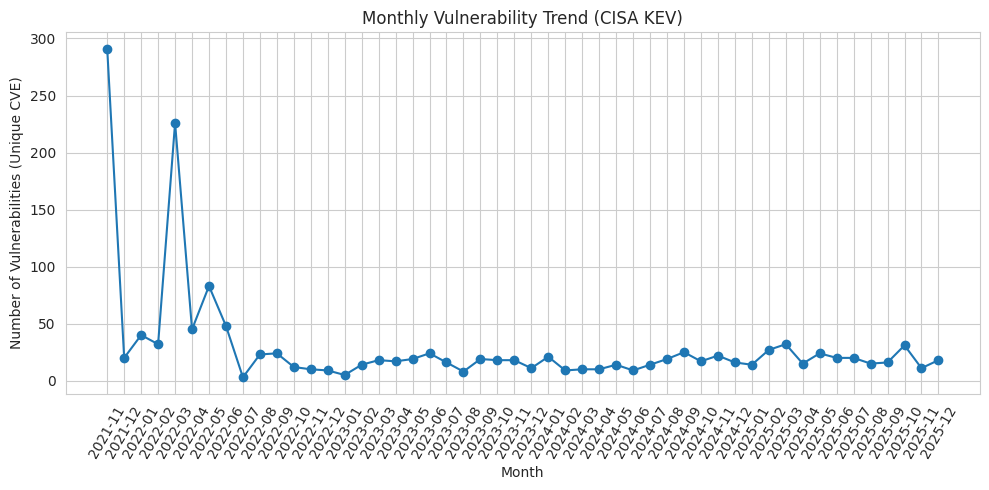

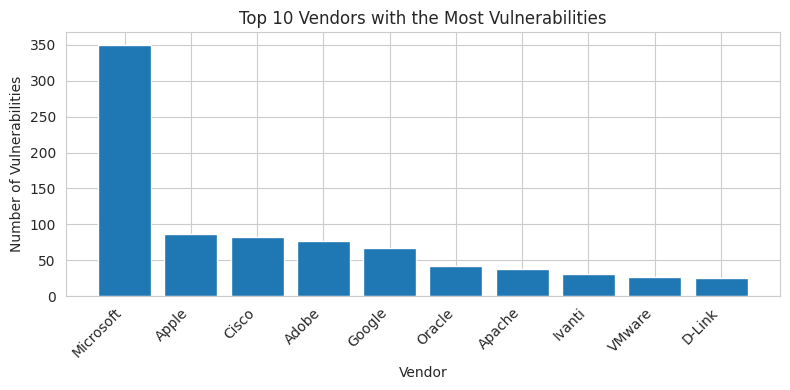

In [87]:
#visualization
plt.figure(figsize=(10,5))
plt.plot(monthly_trend["month_key"], monthly_trend["vuln_count"], marker="o")
plt.xticks(rotation=60)
plt.title("Monthly Vulnerability Trend (CISA KEV)")
plt.xlabel("Month")
plt.ylabel("Number of Vulnerabilities (Unique CVE)")
plt.grid(True)
plt.tight_layout()
plt.show()

plt.figure(figsize=(8,4))
plt.bar(top_vendors["vendor"], top_vendors["vuln_count"])
plt.xticks(rotation=45, ha='right')
plt.title("Top 10 Vendors with the Most Vulnerabilities")
plt.ylabel("Number of Vulnerabilities")
plt.xlabel("Vendor")
plt.tight_layout()
plt.show()

In [88]:
import os
import pandas as pd
import sqlalchemy as sa
from sqlalchemy import create_engine, text

db_path = "risk.db"
engine = create_engine(f"sqlite:///{db_path}", future=True)

In [89]:
#เตรียมdf
df_to_db = df.copy()

for col in ["date_added", "due_date"]:
    if col in df_to_db.columns:
        df_to_db[col] = pd.to_datetime(df_to_db[col], errors="coerce", utc=True).dt.strftime("%Y-%m-%d")

In [90]:
#เอาdfเก็บในsqlite
df_to_db.to_sql("kev_vulns", con=engine, if_exists="replace", index=False)

1482

In [91]:
with engine.begin() as conn:
    conn.exec_driver_sql("CREATE INDEX IF NOT EXISTS idx_kev_date ON kev_vulns(date_added);")
    if "vendor" in df_to_db.columns:
        conn.exec_driver_sql("CREATE INDEX IF NOT EXISTS idx_kev_vendor ON kev_vulns(vendor);")

In [92]:
#ตรวจ risk.db
with engine.connect() as conn:
    rowcount = conn.execute(text("SELECT COUNT(*) FROM kev_vulns")).scalar_one()
    sample = pd.read_sql(text("""
        SELECT cve_id, vendor, product, date_added
        FROM kev_vulns
        ORDER BY date_added DESC
        LIMIT 5;
    """), conn)


In [93]:
#สรุปผล
print(f"เขียนตาราง kev_vulns ลง db '{db_path}' เรียบร้อย: {rowcount:,} แถว")
print("ตัวอย่าง 5 แถวล่าสุด:")
print(sample.to_string(index=False))
print("\n[SUMMARY] DB file exists:", os.path.exists(db_path), "| Size (bytes):", os.path.getsize(db_path) if os.path.exists(db_path) else 0)


เขียนตาราง kev_vulns ลง db 'risk.db' เรียบร้อย: 1,482 แถว
ตัวอย่าง 5 แถวล่าสุด:
        cve_id     vendor           product date_added
CVE-2025-14733 WatchGuard           Firebox 2025-12-19
CVE-2025-20393      Cisco Multiple Products 2025-12-17
CVE-2025-40602  SonicWall SMA1000 appliance 2025-12-17
CVE-2025-59374       ASUS       Live Update 2025-12-17
CVE-2025-59718   Fortinet Multiple Products 2025-12-16

[SUMMARY] DB file exists: True | Size (bytes): 925696


In [94]:
import os
import pandas as pd
import sqlalchemy as sa
from sqlalchemy import create_engine, text

In [95]:
#checkว่าเชื่อม db ยัง
db_path = "risk.db"
engine = create_engine(f"sqlite:///{db_path}", future=True)

assert os.path.exists(db_path), "ไม่พบ risk.db"

In [96]:
#query monthly trend + rolling 6 m
q_trend_rolling = """
WITH m AS (
  SELECT
    month_key,
    COUNT(DISTINCT cve_id) AS vuln_count
  FROM kev_vulns
  WHERE month_key IS NOT NULL
  GROUP BY month_key
)
SELECT
  month_key,
  vuln_count,
  SUM(vuln_count) OVER (
    ORDER BY month_key
    ROWS BETWEEN 5 PRECEDING AND CURRENT ROW
  ) AS rolling_6m
FROM m
ORDER BY month_key;
"""

In [97]:
#query monthly trend with vendor
q_trend_by_vendor = """
WITH m AS (
  SELECT
    month_key,
    vendor,
    COUNT(DISTINCT cve_id) AS vuln_count
  FROM kev_vulns
  WHERE month_key IS NOT NULL
  GROUP BY month_key, vendor
)
SELECT * FROM m
ORDER BY month_key, vendor;
"""

In [98]:
#Top vendors in the last 12 m
q_top_vendor_12m = """
WITH bounds AS (
  SELECT
    date(strftime('%Y-%m-01', MAX(date_added))) AS max_month_start,
    date(strftime('%Y-%m-01', MAX(date_added)), '-11 months') AS cutoff_month_start
  FROM kev_vulns
),
filtered AS (
  SELECT k.vendor, k.cve_id
  FROM kev_vulns k
  JOIN bounds b
    ON date(k.date_added) >= b.cutoff_month_start
)
SELECT
  vendor,
  COUNT(DISTINCT cve_id) AS cve_count_12m
FROM filtered
GROUP BY vendor
ORDER BY cve_count_12m DESC
LIMIT 10;
"""

In [99]:
#query top 5 vendors each month
q_top5 = """
WITH m AS (
  SELECT month_key, vendor, COUNT(DISTINCT cve_id) AS vuln_count
  FROM kev_vulns
  WHERE month_key IS NOT NULL
  GROUP BY month_key, vendor
),
r AS (
  SELECT
    m.*,
    ROW_NUMBER() OVER (PARTITION BY month_key ORDER BY vuln_count DESC, vendor) AS rk
  FROM m
)
SELECT month_key, vendor, vuln_count
FROM r
WHERE rk <= 5
ORDER BY month_key, rk;
"""

In [100]:
#run quries and preview results
with engine.connect() as conn:
    df_trend = pd.read_sql(text(q_trend_rolling), conn)
    df_top_vendor_12m = pd.read_sql(text(q_top_vendor_12m), conn)
    df_trend_vendor = pd.read_sql(text(q_trend_by_vendor), conn)
    df_top5 = pd.read_sql(text(q_top5), conn)

print("Ran SQL queries successfully.")
print("\n Monthly trend + rolling 6M (head):")
print(df_trend.head(10).to_string(index=False))

print("\n Top vendors (last 12 months):")
print(df_top_vendor_12m.to_string(index=False))

print("\n Trend by vendor (head):")
print(df_trend_vendor.head(10).to_string(index=False))

print("\n Top 5 vendors each month :")
print(df_top5.to_string(index=False))

Ran SQL queries successfully.

 Monthly trend + rolling 6M (head):
month_key  vuln_count  rolling_6m
  2021-11         291         291
  2021-12          20         311
  2022-01          40         351
  2022-02          32         383
  2022-03         226         609
  2022-04          45         654
  2022-05          83         446
  2022-06          48         474
  2022-07           3         437
  2022-08          23         428

 Top vendors (last 12 months):
   vendor  cve_count_12m
Microsoft             39
    Apple              9
    Cisco              8
 Fortinet              8
   Google              7
   Ivanti              7
    Linux              7
   Citrix              5
   D-Link              5
   Oracle              5

 Trend by vendor (head):
month_key    vendor  vuln_count
  2021-11 Accellion           4
  2021-11     Adobe           5
  2021-11   Amcrest           1
  2021-11   Android           2
  2021-11    Apache           9
  2021-11     Apple          23
  

In [101]:
#ดึงคะแนน CVSS จริงจาก NVD API
import requests, time, os, pandas as pd

NVD_API_KEY = "addab4cd-3356-41b9-8d19-34c048617ca5"
NVD_BASE = "https://services.nvd.nist.gov/rest/json/cves/2.0"

#Default ให้ใช้ Simulated data
USE_SIMULATION = True

def fetch_nvd_cvss_for_batch(cve_ids):
    if not cve_ids:
        return {}

    params = [("cveId", cid) for cid in cve_ids]
    # เช็คว่ามี Key ไหม
    headers = {"apiKey": NVD_API_KEY}

    try:
        r = requests.get(NVD_BASE, params=params, headers=headers, timeout=60)
        if r.status_code in (429, 502, 503):
            time.sleep(5)

        r.raise_for_status()
        data = r.json()

        out = {}
        for item in data.get("vulnerabilities", []):
            cve_id = item["cve"]["id"]
            metrics = item["cve"].get("metrics", {})
            cvss = severity = vector = None

            for key in ("cvssMetricV31","cvssMetricV30","cvssMetricV2"):
                if key in metrics:
                    m = metrics[key][0].get("cvssData", {})
                    cvss = m.get("baseScore")
                    severity = m.get("baseSeverity")
                    vector = m.get("vectorString")
                    break

            out[cve_id] = {"cvss": cvss, "severity": severity, "vector": vector}
        return out

    except Exception as e:
        print(f"API Request Error: {e}")
        return {}


In [102]:
def fetch_nvd_cvss_all(cve_ids, batch_size=100, pause_no_key=1.1, pause_with_key=0.2):
    "ทำเป็น batch กัน rate limit"
    mapping = {}
    total = len(cve_ids)
    for i in range(0, total, batch_size):
        batch = cve_ids[i:i+batch_size]
        try:
            res = fetch_nvd_cvss_for_batch(batch)
            mapping.update(res)
            print(f"[NVD] batch {i//batch_size+1}: fetched {len(res)}/{len(batch)}")
        except Exception as e:
            print(f"[WARN] batch {i//batch_size+1} failed: {e}")
        time.sleep(pause_with_key if NVD_API_KEY else pause_no_key)
    return mapping

In [103]:
#เตรียมการคำนวณ exposure score
import pandas as pd
import numpy as np
from datetime import datetime, timezone

#เตรียมคอลัมน์วันที่สำหรับคำนวณอายุช่องโหว่
df_expo = df.copy()
#แปลงให้เป็น datetime
df_expo["date_added"] = pd.to_datetime(df_expo["date_added"], errors="coerce", utc=True)

In [104]:
#ดึง CVSS จริง + รวมเข้ากับ df_expo

#เอา CVE ไม่ซ้ำจาก df_expo
cve_list = (
    df_expo["cve_id"].dropna().astype(str).str.upper().str.strip().unique().tolist()
)
print(f"[CHECK] unique CVE ids: {len(cve_list):,}  ตัวอย่าง: {cve_list[:5]}")

[CHECK] unique CVE ids: 1,482  ตัวอย่าง: ['CVE-2025-14733', 'CVE-2025-59374', 'CVE-2025-40602', 'CVE-2025-20393', 'CVE-2025-59718']


In [105]:
#Run API + check
cvss_map = fetch_nvd_cvss_all(cve_list)

if len(cvss_map) > 0:
    print(f"ดึงข้อมูลจริงได้ทั้งหมด {len(cvss_map)} รายการ")
    USE_SIMULATION = False
else:
    print("API ใช้งานไม่ได้ > สร้าง Simulated Data")
    USE_SIMULATION = True

API Request Error: 404 Client Error: Not Found for url: https://services.nvd.nist.gov/rest/json/cves/2.0?cveId=CVE-2025-14733&cveId=CVE-2025-59374&cveId=CVE-2025-40602&cveId=CVE-2025-20393&cveId=CVE-2025-59718&cveId=CVE-2025-14611&cveId=CVE-2025-43529&cveId=CVE-2018-4063&cveId=CVE-2025-14174&cveId=CVE-2025-58360&cveId=CVE-2025-6218&cveId=CVE-2025-62221&cveId=CVE-2022-37055&cveId=CVE-2025-66644&cveId=CVE-2025-55182&cveId=CVE-2021-26828&cveId=CVE-2025-48633&cveId=CVE-2025-48572&cveId=CVE-2021-26829&cveId=CVE-2025-61757&cveId=CVE-2025-13223&cveId=CVE-2025-58034&cveId=CVE-2025-64446&cveId=CVE-2025-12480&cveId=CVE-2025-62215&cveId=CVE-2025-9242&cveId=CVE-2025-21042&cveId=CVE-2025-48703&cveId=CVE-2025-11371&cveId=CVE-2025-41244&cveId=CVE-2025-24893&cveId=CVE-2025-6204&cveId=CVE-2025-6205&cveId=CVE-2025-54236&cveId=CVE-2025-59287&cveId=CVE-2025-61932&cveId=CVE-2022-48503&cveId=CVE-2025-2746&cveId=CVE-2025-2747&cveId=CVE-2025-33073&cveId=CVE-2025-61884&cveId=CVE-2025-54253&cveId=CVE-2025-47827

In [106]:
#แปลง mapping → DataFrame
cvss_df = (pd.DataFrame.from_dict(cvss_map, orient="index")
           .reset_index().rename(columns={"index":"cve_id"}))

In [107]:
#คำนวณอายุช่องโหว่
as_of = df_expo["date_added"].max()
df_expo["age_days"] = (as_of - df_expo["date_added"]).dt.days

In [108]:
#คำนวณ decay factor
HALF_LIFE = 180.0
df_expo["decay"] = np.power(0.5, df_expo["age_days"] / HALF_LIFE)

In [109]:
#merge เข้ากับ df_expo
df_expo["cve_id"] = df_expo["cve_id"].astype(str).str.upper().str.strip()
df_expo = df_expo.merge(cvss_df, on="cve_id", how="left")

In [110]:
#เติมค่า default เพื่อไม่ให้หลุดการคำนวณ

if USE_SIMULATION:
    print("API ใช้งานไม่ได้ > สร้าง Simulated Data")

    np.random.seed(42)

    # สุ่มคะแนน 1.0 - 10.0 (เน้นค่า 7.5)
    random_cvss = np.random.normal(loc=7.5, scale=1.5, size=len(df_expo))
    df_expo["cvss"] = np.clip(np.round(random_cvss, 1), 1.0, 10.0)

    print(f"สร้างคะแนนจำลอง: {len(df_expo)} รายการ")

else:
    print("ใช้ข้อมูลจริงจาก API")

    #ถ้าเป็น NaN เติม 7.5
    missing_count = df_expo["cvss"].isna().sum()
    if missing_count > 0:
        print(f"หาไม่เจอจำนวน: {missing_count} ตัว > เติมค่ากลาง 7.5")
        df_expo["cvss"] = df_expo["cvss"].fillna(7.5)

print(df_expo["cvss"].describe())

ใช้ข้อมูลจริงจาก API
หาไม่เจอจำนวน: 1476 ตัว > เติมค่ากลาง 7.5
count    1482.000000
mean        7.501215
std         0.061039
min         6.100000
25%         7.500000
50%         7.500000
75%         7.500000
max         8.800000
Name: cvss, dtype: float64


In [111]:
real_count = len(cvss_map)
total_rows = len(df_expo)

print(f"จำนวนที่ดึงสำเร็จ: {real_count}")
print(f"จำนวนที่ต้องจำลอง: {total_rows - real_count}")

จำนวนที่ดึงสำเร็จ: 6
จำนวนที่ต้องจำลอง: 1476


In [112]:
print("[CVSS coverage] describe():")
print(df_expo["cvss"].describe())

[CVSS coverage] describe():
count    1482.000000
mean        7.501215
std         0.061039
min         6.100000
25%         7.500000
50%         7.500000
75%         7.500000
max         8.800000
Name: cvss, dtype: float64


In [113]:
#Exposure = CVSS × decay  + สรุป + export

#คำนวณ exposure
df_expo["exposure_score"] = df_expo["cvss"] * df_expo["decay"]

In [114]:
#สรุปผล
expo_month = (
    df_expo.groupby("month_key", as_index=False)
           .agg(vuln_count=("cve_id","nunique"),
                exposure_sum=("exposure_score","sum"),
                exposure_avg=("exposure_score","mean"))
           .sort_values("month_key")
)
expo_vendor_month = (
    df_expo.groupby(["month_key","vendor"], as_index=False)
           .agg(vuln_count=("cve_id","nunique"),
                exposure_sum=("exposure_score","sum"))
           .sort_values(["month_key","exposure_sum"], ascending=[True, False])
)

print("[Preview] Monthly exposure head:")
print(expo_month.head(10).to_string(index=False))

print("\n[Preview] Top Vendor Risk by Month (All Months):")
print(expo_vendor_month.groupby("month_key").head(1).to_string(index=False))

[Preview] Monthly exposure head:
month_key  vuln_count  exposure_sum  exposure_avg
  2021-11         291      6.591358      0.022651
  2021-12          20      0.518580      0.025929
  2022-01          40      1.210335      0.030258
  2022-02          32      1.076630      0.033645
  2022-03         226      8.513154      0.037669
  2022-04          45      1.901680      0.042260
  2022-05          83      4.070129      0.049038
  2022-06          48      2.540231      0.052921
  2022-07           3      0.180068      0.060023
  2022-08          23      1.586032      0.068958

[Preview] Top Vendor Risk by Month (All Months):
month_key             vendor  vuln_count  exposure_sum
  2021-11          Microsoft          82      1.859792
  2021-12             Apache           3      0.077413
  2022-01          Microsoft           6      0.182874
  2022-02          Microsoft          16      0.537954
  2022-03          Microsoft          70      2.648328
  2022-04          Microsoft         

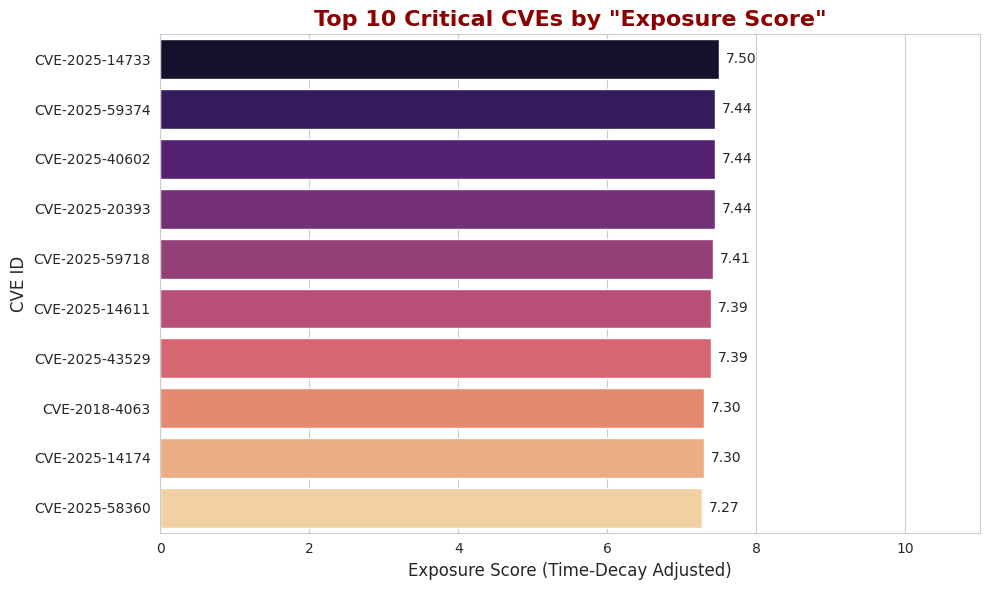

In [115]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(10, 6))
sns.set_style("whitegrid")

#เรียงลำดับเอาคะแนนความเสี่ยงสูงสุด 10 อันดับแรก
top_risk =  df_expo.sort_values(by='exposure_score', ascending=False).head(10)

ax = sns.barplot(x='exposure_score', y='cve_id', data=top_risk, palette='magma', hue='cve_id', legend=False)

plt.title('Top 10 Critical CVEs by "Exposure Score"', fontsize=16, fontweight='bold', color='darkred')
plt.xlabel('Exposure Score (Time-Decay Adjusted)', fontsize=12)
plt.ylabel('CVE ID', fontsize=12)

plt.xlim(0, 11)

for container in ax.containers:
    ax.bar_label(container, fmt='%.2f', padding=5, fontsize=10)

plt.tight_layout()
plt.show()

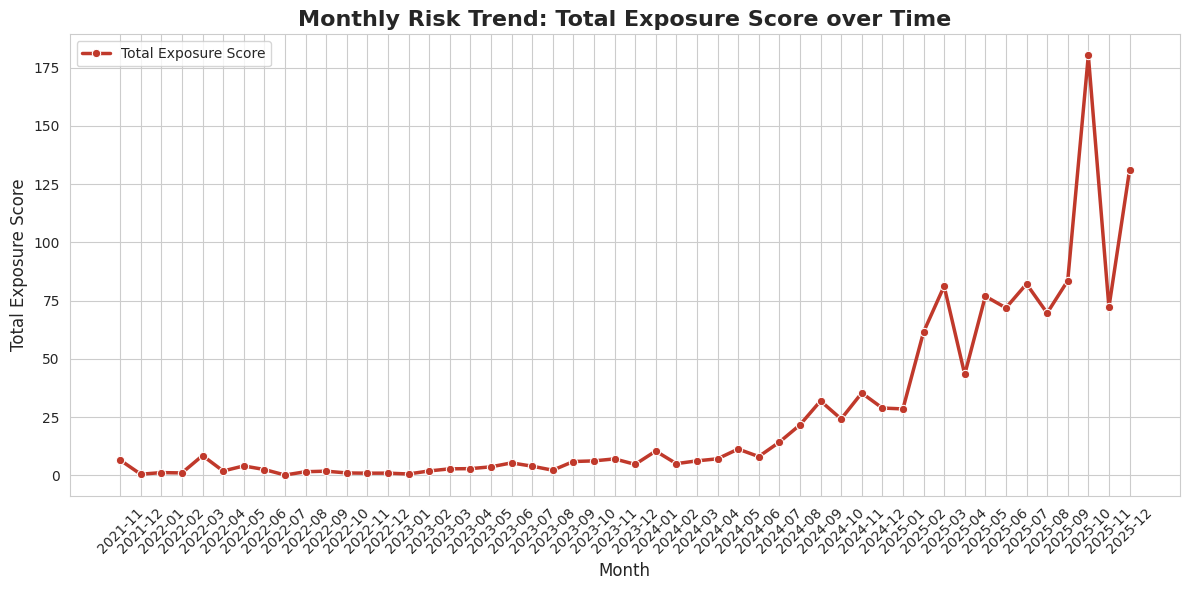

In [116]:
#Monthly Risk Trend
plt.figure(figsize=(12, 6))
sns.set_style("whitegrid")

sns.lineplot(data=expo_month, x='month_key', y='exposure_sum',
             marker='o', color='#c0392b', linewidth=2.5, label='Total Exposure Score')

plt.title('Monthly Risk Trend: Total Exposure Score over Time', fontsize=16, fontweight='bold')
plt.xlabel('Month', fontsize=12)
plt.ylabel('Total Exposure Score', fontsize=12)
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()

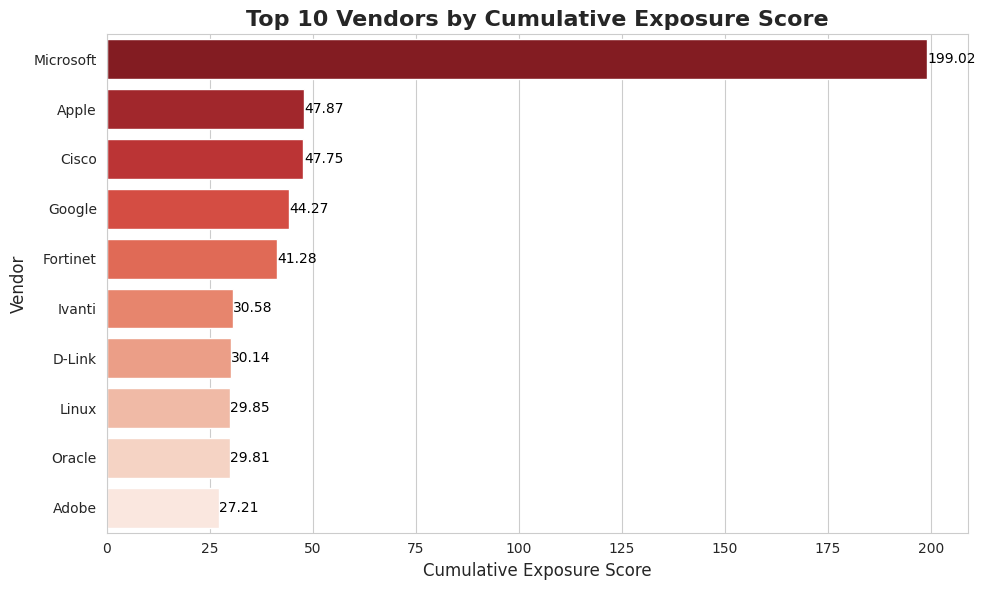

In [117]:
#Top Vendors by Cumulative Risk
#Sum ของแต่ละ Vendor จากทุกเดือน
vendor_agg = expo_vendor_month.groupby('vendor')['exposure_sum'].sum().reset_index()

top_risk_vendors = vendor_agg.sort_values(by='exposure_sum', ascending=False).head(10)

plt.figure(figsize=(10, 6))

sns.barplot(data=top_risk_vendors, x='exposure_sum', y='vendor', palette='Reds_r',hue='vendor', legend=False)

plt.title('Top 10 Vendors by Cumulative Exposure Score', fontsize=16, fontweight='bold')
plt.xlabel('Cumulative Exposure Score', fontsize=12)
plt.ylabel('Vendor', fontsize=12)

for index, value in enumerate(top_risk_vendors['exposure_sum']):
    plt.text(value + 0.1, index, f'{value:.2f}', va='center', color='black')

plt.tight_layout()
plt.show()

In [118]:
#export
import os
os.makedirs("exports", exist_ok=True)

cols_out = ["cve_id","vendor","product","vuln_name","date_added","due_date",
            "known_ransomware_use","cwe","cvss","age_days","decay","exposure_score","month_key"]
cols_out = [c for c in cols_out if c in df_expo.columns]
df_expo[cols_out].to_csv("exports/kev_clean_full.csv", index=False)
expo_month.to_csv("exports/kev_trend_monthly.csv", index=False)
expo_vendor_month.to_csv("exports/kev_vendor_month.csv", index=False)

print("\n[SUMMARY] Exported files:")
for p in ["exports/kev_clean_full.csv","exports/kev_trend_monthly.csv","exports/kev_vendor_month.csv"]:
    print("-", p, "| exists:", os.path.exists(p))


[SUMMARY] Exported files:
- exports/kev_clean_full.csv | exists: True
- exports/kev_trend_monthly.csv | exists: True
- exports/kev_vendor_month.csv | exists: True


In [119]:
import pandas as pd
from google.colab import data_table

data_table.enable_dataframe_formatter()  #interactive table

files = [
    "exports/kev_clean_full.csv",
    "exports/kev_trend_monthly.csv",
    "exports/kev_vendor_month.csv"
]
for f in files:
    print("Preview of:", f)
    try:
        df = pd.read_csv(f)
        display(df.head(20))
    except Exception as e:
        print(f"ไม่สามารถเปิดไฟล์ {f} ได้ :", e)

Preview of: exports/kev_clean_full.csv


,cve_id,vendor,product,vuln_name,date_added,due_date,known_ransomware_use,cwe,cvss,age_days,decay,exposure_score,month_key
0,CVE-2025-14733,WatchGuard,Firebox,WatchGuard Firebox Out of Bounds Write Vulnera...,2025-12-19 00:00:00+00:00,2025-12-26 00:00:00+00:00,Unknown,CWE-787,7.5,0,1.000000,7.500000,2025-12
1,CVE-2025-59374,ASUS,Live Update,ASUS Live Update Embedded Malicious Code Vulne...,2025-12-17 00:00:00+00:00,2026-01-07 00:00:00+00:00,Unknown,CWE-506,7.5,2,0.992328,7.442460,2025-12
2,CVE-2025-40602,SonicWall,SMA1000 appliance,SonicWall SMA1000 Missing Authorization Vulner...,2025-12-17 00:00:00+00:00,2025-12-24 00:00:00+00:00,Unknown,"CWE-862, CWE-250",7.5,2,0.992328,7.442460,2025-12
3,CVE-2025-20393,Cisco,Multiple Products,Cisco Multiple Products Improper Input Validat...,2025-12-17 00:00:00+00:00,2025-12-24 00:00:00+00:00,Unknown,CWE-20,7.5,2,0.992328,7.442460,2025-12
4,CVE-2025-59718,Fortinet,Multiple Products,Fortinet Multiple Products Improper Verificati...,2025-12-16 00:00:00+00:00,2025-12-23 00:00:00+00:00,Unknown,CWE-347,7.5,3,0.988514,7.413855,2025-12
5,CVE-2025-14611,Gladinet,CentreStack and Triofox,Gladinet CentreStack and Triofox Hard Coded Cr...,2025-12-15 00:00:00+00:00,2026-01-05 00:00:00+00:00,Unknown,CWE-798,7.5,4,0.984715,7.385361,2025-12
6,CVE-2025-43529,Apple,Multiple Products,Apple Multiple Products Use-After-Free WebKit ...,2025-12-15 00:00:00+00:00,2026-01-05 00:00:00+00:00,Unknown,CWE-416,7.5,4,0.984715,7.385361,2025-12
7,CVE-2018-4063,Sierra Wireless,AirLink ALEOS,Sierra Wireless AirLink ALEOS Unrestricted Upl...,2025-12-12 00:00:00+00:00,2026-01-02 00:00:00+00:00,Unknown,CWE-434,7.5,7,0.973404,7.300533,2025-12
8,CVE-2025-14174,Google,Chromium,Google Chromium Out of Bounds Memory Access Vu...,2025-12-12 00:00:00+00:00,2026-01-02 00:00:00+00:00,Unknown,NaN,7.5,7,0.973404,7.300533,2025-12
9,CVE-2025-58360,OSGeo,GeoServer,OSGeo GeoServer Improper Restriction of XML Ex...,2025-12-11 00:00:00+00:00,2026-01-01 00:00:00+00:00,Unknown,CWE-611,7.5,8,0.969663,7.272474,2025-12


Preview of: exports/kev_trend_monthly.csv


,month_key,vuln_count,exposure_sum,exposure_avg
0,2021-11,291,6.591358,0.022651
1,2021-12,20,0.518580,0.025929
2,2022-01,40,1.210335,0.030258
3,2022-02,32,1.076630,0.033645
4,2022-03,226,8.513154,0.037669
5,2022-04,45,1.901680,0.042260
6,2022-05,83,4.070129,0.049038
7,2022-06,48,2.540231,0.052921
8,2022-07,3,0.180068,0.060023
9,2022-08,23,1.586032,0.068958


Preview of: exports/kev_vendor_month.csv


,month_key,vendor,vuln_count,exposure_sum
0,2021-11,Microsoft,82,1.859792
1,2021-11,Apple,23,0.520594
2,2021-11,Google,22,0.493734
3,2021-11,Cisco,11,0.248980
4,2021-11,Apache,9,0.203711
5,2021-11,Ivanti,9,0.203711
6,2021-11,VMware,8,0.181076
7,2021-11,Oracle,7,0.158442
8,2021-11,Trend Micro,7,0.158442
9,2021-11,Citrix,6,0.135807
